<a href="https://colab.research.google.com/github/zizilnam/Mini_Project_Machine_Learning_Elo_Merchant_Kaggle/blob/main/Elo_project_Binary_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd/content/drive/MyDrive/KDT/모델링 프로젝트/data/data_1

/content/drive/MyDrive/KDT/모델링 프로젝트/data/data_1


In [ ]:
pip install bayesian-optimization

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from bayes_opt import BayesianOptimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, RepeatedKFold

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgb
import pickle

from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc, accuracy_score, roc_auc_score, log_loss, confusion_matrix, plot_confusion_matrix

import time
import gc
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#https://www.kaggle.com/fabiendaniel/elo-world
#Function to load data into pandas and reduce memory usage

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
train = reduce_mem_usage(pd.read_csv("/content/drive/MyDrive/KDT/모델링 프로젝트/data/train_features_generated.csv", index_col=0))
test = reduce_mem_usage(pd.read_csv("/content/drive/MyDrive/KDT/모델링 프로젝트/data/test_features_generated.csv", index_col=0))

Mem. usage decreased to 100.71 Mb (74.7% reduction)
Mem. usage decreased to 61.19 Mb (74.7% reduction)


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201917 entries, 0 to 201916
Columns: 257 entries, card_id to rare_datapoints
dtypes: float16(194), float32(14), int16(15), int8(33), object(1)
memory usage: 100.7+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123623 entries, 0 to 123622
Columns: 255 entries, card_id to merchant_active_months_lag12_12.0_std
dtypes: float16(195), float32(14), int16(12), int8(33), object(1)
memory usage: 61.2+ MB


train 변수에 결측치가 있는지 확인한다.

In [ ]:
train.isna().sum().any()

False

test 변수에 결측치가 있는지 확인한다.

In [ ]:
test.isna().sum().any()

False

train에서 아웃라이어를 구분하기 위해 아웃라이어를 표시한 rare_datapoint column을 나눠준다.
그리고 train에서 학습에 사용되지 않는 feature들을 제외해준다.

In [ ]:
y_data = train['rare_datapoints']
train.drop(columns = ['rare_datapoints', 'card_id', 'target'], axis=1, inplace=True)

In [ ]:
test.drop(columns=['card_id'], axis = 1, inplace=True)

In [ ]:
train.head()

,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3,feature_3_0,feature_3_1,first_active_month_diff_from_today,year_of_joining,authorized_flag_sum,authorized_flag_mean,category_1_sum,category_1_mean,category_2_1.0_sum,category_2_1.0_mean,category_2_2.0_sum,category_2_2.0_mean,category_2_3.0_sum,category_2_3.0_mean,category_2_4.0_sum,category_2_4.0_mean,category_2_5.0_sum,category_2_5.0_mean,category_3_A_sum,category_3_A_mean,category_3_B_sum,category_3_B_mean,category_3_C_sum,category_3_C_mean,city_id_nunique,state_id_nunique,subsector_id_nunique,merchant_category_id_nunique,merchant_id_nunique,month_lag_sum,month_lag_mean,month_lag_min,...,merchant_active_months_lag6_5.0_std,merchant_active_months_lag6_6.0_sum,merchant_active_months_lag6_6.0_mean,merchant_active_months_lag6_6.0_std,merchant_active_months_lag12_1.0_sum,merchant_active_months_lag12_1.0_mean,merchant_active_months_lag12_1.0_std,merchant_active_months_lag12_2.0_sum,merchant_active_months_lag12_2.0_mean,merchant_active_months_lag12_2.0_std,merchant_active_months_lag12_3.0_sum,merchant_active_months_lag12_3.0_mean,merchant_active_months_lag12_3.0_std,merchant_active_months_lag12_4.0_sum,merchant_active_months_lag12_4.0_mean,merchant_active_months_lag12_4.0_std,merchant_active_months_lag12_5.0_sum,merchant_active_months_lag12_5.0_mean,merchant_active_months_lag12_5.0_std,merchant_active_months_lag12_6.0_sum,merchant_active_months_lag12_6.0_mean,merchant_active_months_lag12_6.0_std,merchant_active_months_lag12_7.0_sum,merchant_active_months_lag12_7.0_mean,merchant_active_months_lag12_7.0_std,merchant_active_months_lag12_8.0_sum,merchant_active_months_lag12_8.0_mean,merchant_active_months_lag12_8.0_std,merchant_active_months_lag12_9.0_sum,merchant_active_months_lag12_9.0_mean,merchant_active_months_lag12_9.0_std,merchant_active_months_lag12_10.0_sum,merchant_active_months_lag12_10.0_mean,merchant_active_months_lag12_10.0_std,merchant_active_months_lag12_11.0_sum,merchant_active_months_lag12_11.0_mean,merchant_active_months_lag12_11.0_std,merchant_active_months_lag12_12.0_sum,merchant_active_months_lag12_12.0_mean,merchant_active_months_lag12_12.0_std
0,0,0,0,0,1,0,1,0,0,1,56,2017,270,0.954102,0,0.000000,280.0,0.989258,0.0,0.0,0.0,0.000000,0.0,0.000000,3.0,0.010597,279.0,0.98584,4.0,0.014137,0.0,0.000000,9,3,21,46,117,-983.0,-3.472656,-8,...,0.058929,281.0,0.975586,0.154297,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,1,0.003471,0.058929,0,0.0,0.0,5.0,0.017365,0.130859,0,0.0,0.0,0,0.000000,0.000000,2,0.006943,0.083191,0,0.0,0.0,274.0,0.951172,0.215454
1,0,0,0,1,0,1,0,0,1,0,56,2017,345,0.969238,31,0.087097,325.0,0.913086,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,282.0,0.791992,72.0,0.202271,9,3,24,58,148,-1752.0,-4.921875,-12,...,0.000000,371.0,1.000000,0.000000,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.000000,0.000000,0,0.0,0.0,9.0,0.024261,0.154053,0,0.0,0.0,0,0.000000,0.000000,3,0.008087,0.089661,0,0.0,0.0,359.0,0.967773,0.177124
2,0,1,0,0,0,0,1,0,1,0,68,2016,42,0.954590,0,0.000000,4.0,0.090881,0.0,0.0,0.0,0.000000,0.0,0.000000,40.0,0.909180,44.0,1.00000,0.0,0.000000,0.0,0.000000,5,2,8,9,14,-368.0,-8.367188,-13,...,0.000000,45.0,1.000000,0.000000,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.000000,0.000000,0,0.0,0.0,1.0,0.022217,0.149048,0,0.0,0.0,0,0.000000,0.000000,1,0.022217,0.149048,0,0.0,0.0,43.0,0.955566,0.208374
3,0,0,0,1,0,0,0,1,1,0,56,2017,84,1.000000,13,0.154785,12.0,0.142822,0.0,0.0,0.0,0.000000,59.0,0.702148,0.0,0.000000,0.0,0.00000,74.0,0.880859,7.0,0.083313,7,5,15,28,57,-206.0,-2.453125,-5,...,0.000000,96.0,1.000000,0.000000,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.000000,0.000000,0,0.0,0.0,9.0,0.093750,0.292969,0,0.0,0.0,3,0.031250,0.174927,2,0.020828,0.143555,0,0.0,0.0,82.0,0.854004,0.354736
4,1,0,0,0,0,0,0,1,1,0,56,2017,164,0.970215,17,0.100586,12.0,0.070984,0.0,0.0,7.0,0.041412,132.0,0.781250,1.0,0.005917,0.0,0.00000,160.0,0.946777,8.0,0.047333,7,7,19,37,102,-115.0,-0.680664,-3,...,0.07495

데이터를 스플릿하고 학습시킨 뒤 평가까지하는 함수를 만든다.

In [ ]:
def LGBM_CV(
            num_leaves,
            max_depth,
            n_estimators,
            min_split_gain,
            subsample,
            min_child_samples,
            colsample_bytree,
            reg_alpha,
            reg_lambda
):

  folds = StratifiedKFold(n_splits = 3, shuffle=True, random_state=5)
  oof = np.zeros(train.shape[0])

  for fold_, (train_idx, val_idx) in enumerate(folds.split(train, y_data)):
    print("Fold:", fold_)
    trn_data = lgb.Dataset(train.iloc[train_idx], label = y_data.iloc[train_idx])
    val_data = lgb.Dataset(train.iloc[val_idx], label = y_data.iloc[val_idx])

    params = {  
                'task': 'train',
                'objective' : 'binary',
                'boosting_type' : 'goss',
                'num_leaves' : int(num_leaves),
                'max_depth' : int(max_depth),
                'learning_rate' : 0.01,
                'n_estimators' : int(n_estimators),
                'is_unbalance' : True,
                'min_split_gain' : min_split_gain,
                'subsample' : subsample,
                'min_child_samples' : int(min_child_samples),
                'colsample_bytree' : colsample_bytree,
                'n_jobs' : -1,
                'reg_alpha' : reg_alpha,
                'reg_lambda' : reg_lambda,
                'metric': 'binary_logloss'
    }

    clf = lgb.train(params,
                    trn_data,
                    valid_sets = [trn_data, val_data],
                    verbose_eval = 1000,
                    early_stopping_rounds = 200
                    )
    
    oof[val_idx] = clf.predict(train.iloc[val_idx])
  
  #oof = np.where(oof > 0.5, 1, 0) # Change predictions to 0-1 output
  #Change the error metric if needed
  return -log_loss(y_data, oof)

Bayesian Optimization의 하이퍼파라미터 범위를 지정해준다.

In [ ]:
LGB_BO = BayesianOptimization(LGBM_CV, {
    'min_split_gain': (0, 1),
    'subsample': (0, 1) ,
    'min_child_samples': (10, 200),
    'colsample_bytree': (0, 1),
    'reg_alpha': (0, 1),
    'reg_lambda': (0, 1),
    'max_depth': (4, 10),
    'num_leaves': (5, 200),
    'n_estimators' : (10, 750)
    })

위의 함수를 이용해 범위 내에 있는 하이퍼 파라미터 중 최적의 값을 선정한다.
코드 실행 시간이 길면 얼마나 오래 걸리는 지 궁금하기 때문에 걸린 시간을 보여주는 코드도 쓴다.

In [ ]:
start_time = time.time()
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=2, n_iter=30, acq='ei', xi=0.0)
    
print("Time taken", time.time()-start_time)
print('-'*130)
print('Final Results')
print('Maximum  value: %f' % LGB_BO.max['target'])
print('Best  parameters: ', LGB_BO.max['params'])

|   iter    |  target   | colsam... | max_depth | min_ch... | min_sp... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
Fold: 0
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0585984	valid_1's binary_logloss: 0.0589774
Fold: 1
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0586433	valid_1's binary_logloss: 0.0589461
Fold: 2
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0587114	valid_1's binary_logloss: 0.0589054
|  1        | -0.05894  |  0.11     |  5.842    |  22.89    |  0.568    |  744.7    |  33.42    |  0.6092   |  0.4921   |  0.6763   |
Fold: 0
Training until validation scores don't im

'colsample_bytree': 0.916696198086027, 'max_depth': 9.633270599649617, 'min_child_samples': 21.22845335671823, 'min_split_gain': 0.6328282464527148, 'n_estimators': 13.73601660809571, 'num_leaves': 194.78993625112014, 'reg_alpha': 0.7154684277016825, 'reg_lambda': 0.3936289516480598, 'subsample': 0.040175028233326415

# Training with the best parameters

위 코드에서 구한 최고의 하이퍼 파라미터로 학습시켜봅니다.
param dict에 베스트 파라미터를 입력합니다.
leaves, max_depth, min_child_samples는 int의 형태를 갖고 있어야해서 반올림해줍니다.

In [ ]:
params = {
          'colsample_bytree': 0.916696198086027,
          'max_depth': 10,
          'min_child_samples': 21,
          'min_split_gain': 0.6328282464527148,
          'n_estimators': 13.73601660809571,
          'num_leaves': 195,
          'reg_alpha': 0.7154684277016825,
          'reg_lambda': 0.3936289516480598,
          'subsample': 0.040175028233326415
          }

In [ ]:
trn_data = lgb.Dataset(train, label=y_data)

clf = lgb.train(params,
                trn_data,
                10000,
                verbose_eval=500)

In [ ]:
train_preds = clf.predict(train)

# Save the model

In [ ]:
with open('Binary_Classification.pkl', 'wb') as f:
  pickle.dump(clf, f)

In [ ]:
with open('Binary_Classification.pkl', 'rb') as f:
  clf = pickle.load(f)

# Result:

AUC score : out lier냐 아니냐를 구분하는 모델의 정확도를 구해봅시다.

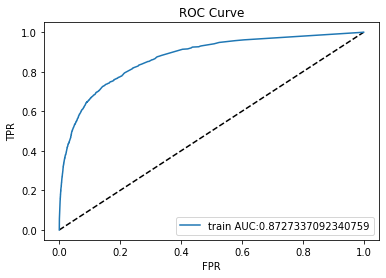

In [ ]:
plt.plot([0,1], [0,1], 'k--')

fpr, tpr, threshold = roc_curve(y_data, train_preds)
auc_score = roc_auc_score(y_data, train_preds)
plt.plot(fpr, tpr, label="train AUC:" +str(auc_score))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.show()

Confusion Matrix도 만들어 봅니다.

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
        plt.grid(False)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

Train accuracy: 0.9403913489205961
**************************************************


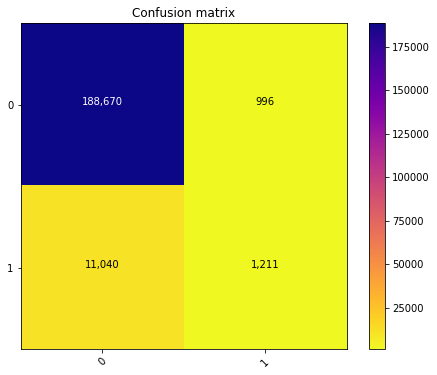

In [ ]:

#This is decided based on trial and error
threshold = 0.030
train_pred_labels = np.where(train_preds > threshold, 1, 0)
#test_predictions_labels = np.where(test_predictions > threshold, 1, 0)

print("Train accuracy:", accuracy_score(train_pred_labels, y_data))
print('*'*50)
plot_confusion_matrix(confusion_matrix(train_pred_labels, y_data), target_names=[0,1], normalize=False, cmap= plt.get_cmap('plasma_r'))

In [ ]:
with open('Binary_Classification.pkl', 'rb') as f:
  clf = pickle.load(f)

# Prob predictions for actual test data

In [ ]:
train_prob = clf.predict(train)
test_prob = clf.predict(test)

threshold = 0.030

train_labels = np.where(train_prob > threshold, 1, 0)
test_labels = np.where(test_prob > threshold, 1, 0)

In [ ]:
print("Accuracy on entire train data:", accuracy_score(train_labels, y_data))

Accuracy on entire train data: 0.9403913489205961


In [ ]:
# Saving our predictions for further use
with open('prob_labels_train.pkl', 'wb') as f:
  pickle.dump(train_prob, f)

with open('prob_labels_test.pkl', 'wb') as f:
  pickle.dump(test_prob, f)

In [ ]:
# Saving our predictions for further use
with open('predicted_labels_train.pkl', 'wb') as f:
  pickle.dump(train_labels, f)

with open('predicted_labels_test.pkl', 'wb') as f:
  pickle.dump(test_labels, f)